In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import scienceplots

qml.drawer.use_style(style='sketch')

## Description of Quantum matrix multiplication algorithm

### Classical matrix multiplication

**Problem**: Given positive definite matrix $A$ and the vector $x$, find the vector $b$ such that $b = Ax$.

1. Find eigenvalues and eigenvectors of $A$.
   $$
   Av_r = \lambda_r v_r
   $$

2. Express $x$ in terms of eigenvectors of $A$.
   $$
   x = \sum_{r=1}^{R} (v_r^T x) v_r
   $$

3. Multiply $A$ and $x$.
   $$
   Ax = \sum_{r=1}^{R} \lambda_r (v_r^T x) v_r
   $$

### Quantum matrix multiplication

1. Prepare the quantum state $|\psi_x\rangle$ corresponding to the vector $x$ via amplitude encoding.
   $$
   |\psi_x\rangle = \sum_{r=1}^{R} x_i |i\rangle
   $$

2. Construct the unitary operator $U = e^{2\pi i A}$ using _Hamiltonian simulation_. (But this time we assume $A$ is Hermitian and $U$ is computed by hand)

3. Prepare ancilla qubits and apply controlled sequence of $U$ to use the quantum phase estimation algorithm.
   $$
   \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} U^k|k\rangle |\psi_x\rangle = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} |k\rangle \sum_{r=1}^{R} e^{2\pi i k \lambda_r} \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle
   $$

4. Apply iQFT to register $|k\rangle$ to obtain the eigenvalues $\lambda_r$.
   $$
   \sum_{l=0}^{2^{n}-1} \sum_{r=1}^{R} \alpha_{l|r}|l\rangle \otimes \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle
   $$
   where
   $$
   \alpha_{l|r} = \frac{1}{2^{n}} \sum_{k=0}^{2^n -1}e^{2\pi i k \delta} e^{-2\pi i k (l - a_r) / 2^{n}} \quad \text{ where } 2^n \lambda_r = a_r + 2^n \delta_r
   $$
   If $\delta = 0$, then $\alpha_{l|r} = \delta_{l, a_r}$, so that
   $$
   |\Psi\rangle = \sum_{r=1}^{R} |a_r\rangle \otimes \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle
   $$

5. Use another ancilla qubit to encoding the eigenvalues into the amplitudes. This process is called _Ancilla Qubit Encoding_.
   To implement this, use controlled sequence of rotation gates.
   $$
   \text{AQE} (|0\rangle \otimes |a_r\rangle) = \left(\sqrt{1-a_r^2}|0\rangle + a_r |1\rangle \right) \otimes |a_r \rangle
   $$
   > _How to implement the controlled rotation gates?_
   >
   > Our goal is to find $\theta$ to input into the rotation gate $R_y(\theta)$.
   > $$
   > \begin{aligned}
   >  R Y(\theta)|0\rangle_{\mathrm{a}} & =\left(\begin{array}{cc}
   >  \cos \left(\frac{\theta}{2}\right) & -\sin \left(\frac{\theta}{2}\right) \\
   >  \sin \left(\frac{\theta}{2}\right) & \cos \left(\frac{\theta}{2}\right)
   >  \end{array}\right)\left(\begin{array}{l}
   >  1 \\
   >  0
   >  \end{array}\right) \\
   >  & =\cos \left(\frac{\theta}{2}\right)|0\rangle_{\mathrm{a}}+\sin \left(\frac{\theta}{2}\right)|1\rangle_{\mathrm{a}}
   >  \end{aligned}
   > $$
   > Our desired $\theta$ is $2\arcsin \lambda_r$. From QPE, we can find the binary representation of $\lambda_r$ and then calculate $\theta$.

7. Now, the state is
   $$
   |\Psi\rangle = \sum_{r=1}^R \left(\sqrt{1-a_r^2}|0\rangle + a_r |1\rangle \right) \otimes |a_r\rangle \otimes \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle
   $$
   Then let apply inverse QPE to return $|a_r\rangle$ to $|0\rangle^{\otimes n}$.
   
   1. Apply QFT to the $|a_r\rangle$ register.
      $$
      \text{QFT}|a_r\rangle = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n - 1} e^{2\pi i a_r k / 2^n} |k\rangle
      $$

   2. Apply controlled sequence of $(U^\dagger)^{2^j}$.
      $$
      \begin{aligned}
      &\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n - 1} |k\rangle e^{2\pi i a_r k / 2^n} e^{-2\pi i k \lambda_r} \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle \\
      \Rightarrow ~ &\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n - 1} |k\rangle e^{2\pi i (a_r - 2^n \lambda_r) k / 2^n} \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle \\
      \Rightarrow ~ &\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n - 1} |k\rangle \otimes \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle
      \end{aligned}
      $$

   3. Apply $H^{\otimes n}$ to the $|a_r\rangle$ register.
      $$
      H^{\otimes n} \left(\frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} |k\rangle \right) = |0\rangle^{\otimes n}
      $$

   $$
   \therefore |\Psi\rangle = \sum_{r=1}^R (\sqrt{1-a_r^2}|0\rangle + a_r |1\rangle) \otimes |0\rangle^{\otimes n} \otimes \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle
   $$

8. Ignore c-register and select the state $|1\rangle$ from the ancilla qubit.
   $$
   \sum_{r=1}^R a_r \langle \psi_{v_r} | \psi_x \rangle |\psi_{v_r}\rangle
   $$
   This is the quantum state corresponding to the vector $Ax$.

## Prepare operations for QMM

In [2]:
def unitary_matrix_from_hermitian(A):
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    D = np.diag(np.exp(2j * np.pi * eigenvalues))
    U = np.dot(eigenvectors, np.dot(D, eigenvectors.conj().T))
    return U

### Implement AQE

In [3]:
def MultipleControlledRY(target_wire, control_wires, lamb1, lamb2):
    """
    Apply a multiple controlled RY gate to the target wire, with control on the control wires.

    Args:
        target_wire (int): the target wire the RY gate acts on
        control_wires (list[int]): the control wires
        lamb (float): the eigenvalue. lamb should be converted to the qubit state (e.g. 0.25 (n=2) -> 01)
    """
    n = len(control_wires)
    angle1 = 2 * np.arcsin(lamb1)
    lamb1_bin = format(int(lamb1 * 2**n), f'0{n}b')
    control_values1 = [int(bit) for bit in lamb1_bin]

    angle2 = 2 * np.arcsin(lamb2)
    lamb2_bin = format(int(lamb2 * 2**n), f'0{n}b')
    control_values2 = [int(bit) for bit in lamb2_bin]
    # print(control_values)

    qml.ctrl(qml.RY, control=control_wires, control_values=control_values1)(angle1, wires=target_wire)
    qml.ctrl(qml.RY, control=control_wires, control_values=control_values2)(angle2, wires=target_wire)

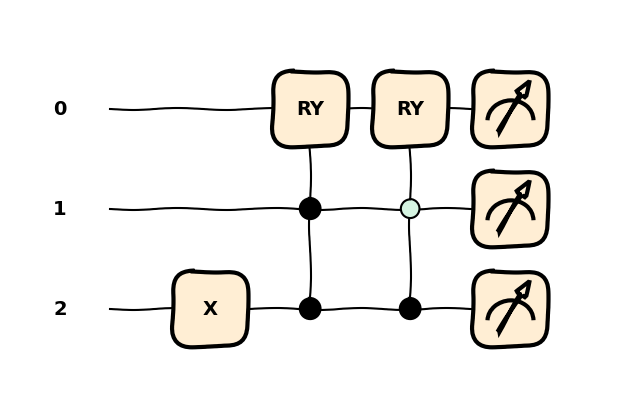

In [4]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def aqe_test(lamb1, lamb2):
    qml.PauliX(wires=2)
    MultipleControlledRY(0, [1, 2], lamb1, lamb2)
    return qml.state()

lamb1 = 0.75
lamb2 = 0.25

qml.draw_mpl(aqe_test)(lamb1, lamb2)
plt.show()

In [5]:
state = aqe_test(lamb1, lamb2)
print(state)

[0.        +0.j 0.96824584+0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.25      +0.j 0.        +0.j 0.        +0.j]


[0.        +0.j 0.        +0.j 0.        +0.j 0.66143783+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.75      +0.j]


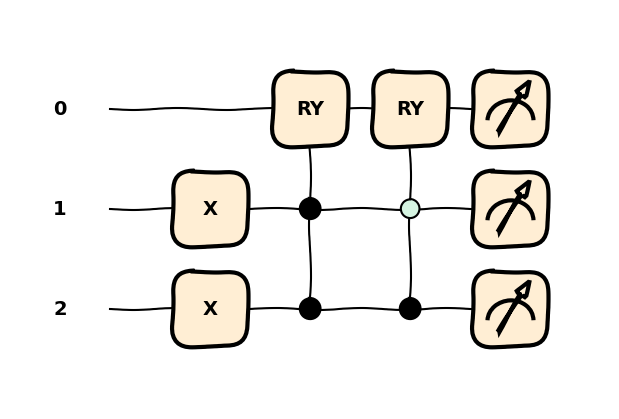

In [6]:
@qml.qnode(dev)
def aqe_test(lamb1, lamb2):
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    MultipleControlledRY(0, [1, 2], lamb1, lamb2)
    return qml.state()

state = aqe_test(lamb1, lamb2)
print(state)

qml.draw_mpl(aqe_test)(lamb1, lamb2)
plt.show()

### QPE Test

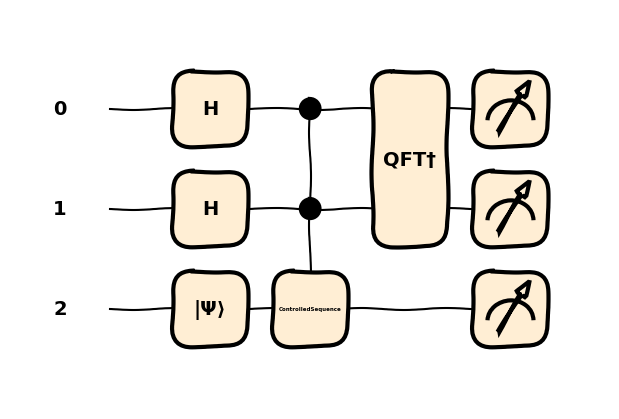

In [7]:
A = np.array([[0.5, 0.25], [0.25, 0.5]])
U = unitary_matrix_from_hermitian(A)
x = np.array([1, 0])

dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def qpe_test(U, x):
    # Encode the input vector x into the amplitudes of the state (here, only 2d vectors)
    qml.AmplitudeEmbedding(features=x, wires=2, normalize=True)

    # Apply Hadamard gate to the first n qubits
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    # Apply controlled unitary operations
    qml.ControlledSequence(qml.QubitUnitary(U, wires=2), control=range(2))

    # Apply inverse QFT
    qml.adjoint(qml.QFT)(wires=range(2))

    # Measure c-register and return the probability distribution
    return qml.state()

qml.draw_mpl(qpe_test)(U, x)
plt.show()

In [8]:
qpe_test(U, x).round(2)

tensor([ 0. +0.j,  0. -0.j,  0.5+0.j, -0.5+0.j,  0. -0.j, -0. +0.j,
         0.5-0.j,  0.5+0.j], requires_grad=True)

### QMM

In [9]:
def gen_qmm(n: int, A):
    U = unitary_matrix_from_hermitian(A)
    U_inv = np.linalg.inv(U)
    dev1 = qml.device("default.qubit", wires=n+1) # c-register, encoding x
    dev2 = qml.device("lightning.qubit", wires=n+2, shots=10000, mcmc=True) # ancilla, c-register, encoding x
    
    @qml.qnode(dev1)
    def eigenvalue_circuit(x):
        # Encode the input vector x into the amplitudes of the state (here, only 2d vectors)
        qml.AmplitudeEmbedding(features=x, wires=n, normalize=True)

        # Apply Hadamard gate to the first n qubits
        for i in range(n):
            qml.Hadamard(wires=i)

        # Apply controlled unitary operations
        qml.ControlledSequence(qml.QubitUnitary(U, wires=n), control=range(n))

        # Apply inverse QFT
        qml.adjoint(qml.QFT)(wires=range(n))

        # Measure c-register and return the probability distribution
        return qml.probs(wires=range(n))
    
    @qml.qnode(dev2)
    def final_circuit(x, lamb1, lamb2):
        # Encode the input vector x into the amplitudes of the state (here, only 2d vectors)
        qml.AmplitudeEmbedding(features=x, wires=n+1, normalize=True)

        # Apply Hadamard gate to the c-register
        for i in range(1, n+1):
            qml.Hadamard(wires=i)

        # Apply controlled unitary operations
        qml.ControlledSequence(qml.QubitUnitary(U, wires=n+1), control=range(1,n+1))

        # Apply inverse QFT
        qml.adjoint(qml.QFT)(wires=range(1,n+1))

        # Apply controlled rotations for |lambda> -> |lambda> (sqrt(1-lambda^2) |0> + lambda |1>)
        MultipleControlledRY([0], range(1, n+1), lamb1, lamb2)

        # Apply QFT
        qml.QFT(wires=range(1,n+1))

        # Apply controlled unitary operations
        qml.ControlledSequence(qml.QubitUnitary(U_inv, wires=n+1), control=range(1,n+1))

        # Apply Hadamard gate to the c-register
        for i in range(1, n+1):
            qml.Hadamard(wires=i)
        
        # Return the state of the last qubit and the measurement result
        return qml.sample(wires=[0, n+1])
    
    def circuit(x):
        lamb_prob = eigenvalue_circuit(x)
        # lamb_cand = np.arange(2**n) / 2**n
        sorted_lamb_prob = np.argsort(lamb_prob)[::-1]
        lamb1 = sorted_lamb_prob[0] / 2**(n)
        lamb2 = sorted_lamb_prob[1] / 2**(n)
        print(lamb1, lamb2)
        samples = final_circuit(x, lamb1, lamb2)
        return samples
    
    return circuit, (dev1, eigenvalue_circuit), (dev2, final_circuit)

In [10]:
A = np.array([[0.5, 0.25], [0.25, 0.5]])
x = np.array([1, 2])

A @ x

tensor([1.  , 1.25], requires_grad=True)

In [11]:
eigv = np.linalg.eig(A)
print(eigv)

EigResult(eigenvalues=array([0.75, 0.25]), eigenvectors=tensor([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]], requires_grad=True))


In [12]:
qmm_circuit, (dev1, ec), (dev2, fc) = gen_qmm(2, A)

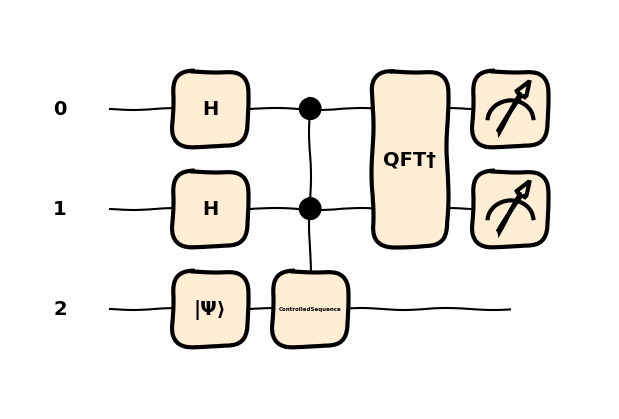

In [13]:
qml.draw_mpl(ec)(x)
plt.show()

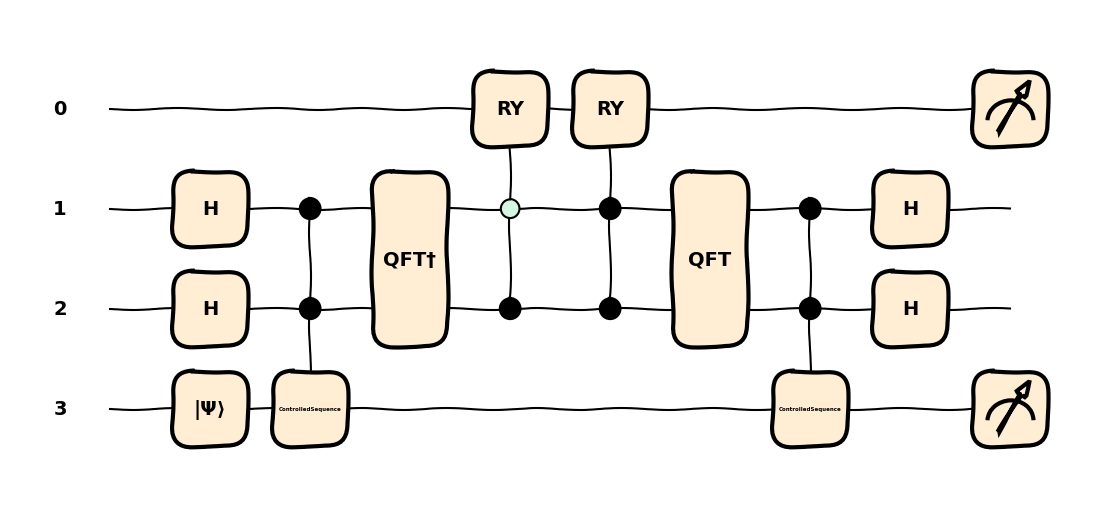

In [14]:
qml.draw_mpl(fc)(x, 0.25, 0.75)
plt.show()

In [15]:
result = qmm_circuit(x)

0.75 0.25


In [16]:
result

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [1, 1]])

In [17]:
meas_one = result[:,0] == 1
result_zero = result[meas_one & (result[:,1] == 0)]
result_one = result[meas_one & (result[:,1] == 1)]

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(result[:,0], result[:,1])
cm

array([[ 527, 4315],
       [1987, 3171]])

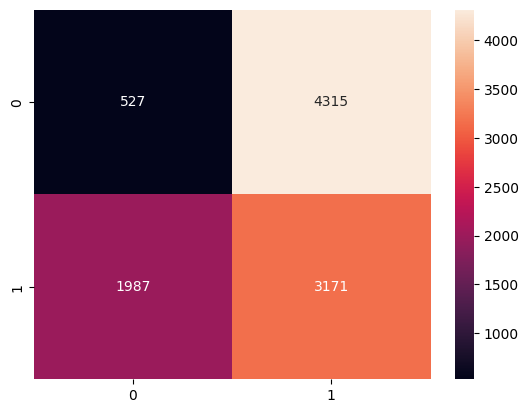

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [20]:
res = np.array([result_zero.shape[0], result_one.shape[0]])
res

tensor([1987, 3171], requires_grad=True)

In [21]:
np.sqrt(res) / np.linalg.norm(np.sqrt(res))

tensor([0.62066644, 0.78407472], requires_grad=True)

In [22]:
B = A @ x
B / np.linalg.norm(B)

tensor([0.62469505, 0.78086881], requires_grad=True)